In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14098862338290305090
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 6735474197
locality {
  bus_id: 1
}
incarnation: 8131133535121368825
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0"
]


In [2]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import *
from keras import regularizers
import numpy as np
import tensorflow as tf
import  matplotlib.pyplot as plt
import matplotlib
import itertools
from numpy import*
from sklearn.utils import shuffle
%matplotlib inline
import random as rn
import os
os.environ['PYTHONASHSEED']= '0'

Using TensorFlow backend.


In [3]:
#setting  the  seed for nummy_gennerated random numbers
np.random.seed(7)
#seting the seed for python random numbers
rn.seed(124)
#seting the seed for tensorflow random numbers
tf.set_random_seed(57)

In [4]:
batch_size = 8
n_epochs = 50


In [5]:

##### calculate  number of imag
import os
classes_name_train = []
files_name_train = []
classes_name_test = []
files_name_test = []
for root, dirs, files in os.walk('Data/Train'):  
    for name in dirs:
        classes_name_train.append(name)
    for name1 in files:
        files_name_train.append(name1)
        
for root, dirs, files in os.walk('Data/Test'):  
    for name in dirs:
        classes_name_test.append(name)
    for name1 in files:
        files_name_test.append(name1)

no_training = len(files_name_train)
no_testing = len(files_name_test)
        
print(len(classes_name_train))
print(len(files_name_train))
print(len(classes_name_test))
print(len(files_name_test))
number_classes = len(classes_name_train)

5
5211
5
259


In [6]:
train_path = 'Data/Train' 
valid_path = 'Data/Test' 
classes = ['A','B','C','Point','V']
num_classes = 5

In [7]:

train_datagen=ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False
                                 )

test_datagen=ImageDataGenerator(rescale=1./255)

In [8]:

train_batches = train_datagen.flow_from_directory(train_path, target_size = (200,200), classes = classes, batch_size = batch_size)
valid_batches = test_datagen.flow_from_directory(valid_path, target_size = (200,200), classes = classes, batch_size = batch_size)

Found 5211 images belonging to 5 classes.
Found 259 images belonging to 5 classes.


In [9]:
import pandas as pd

In [10]:
train_df = pd.DataFrame(columns=["fname", "label"])
train_df["fname"] = train_batches.filenames
train_df["label"] = train_batches.classes

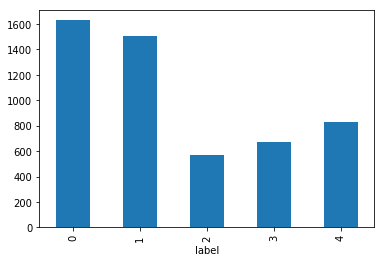

In [11]:
train_df.groupby("label")["fname"].agg("count").plot.bar()

In [12]:
test_df = pd.DataFrame(columns=["fname", "label"])
test_df["fname"] = valid_batches.filenames
test_df["label"] = valid_batches.classes

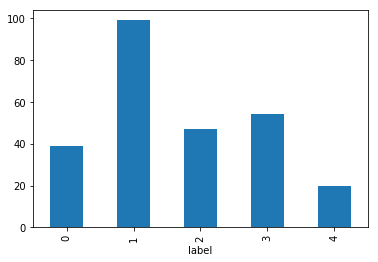

In [13]:
test_df.groupby("label")["fname"].agg("count").plot.bar()

In [14]:
y_train = train_batches.classes
y_val = valid_batches.classes

In [15]:
from sklearn.utils import class_weight
train_class_weight = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train)

In [16]:
from sklearn.utils import class_weight
valid_class_weight = class_weight.compute_class_weight('balanced',
                                             np.unique(y_val),
                                             y_val)

In [17]:

#################################################
def CNN_model(input_tensor=None, input_shape=None, pooling=None, classes=5):
    
    # Determine proper input shape
    if input_shape == None:
        input_shape = (200,200,3)
    
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block11_conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block11_pool')(x)

    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block12_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block12_pool')(x)
    x = Dropout(0.5)(x) 
    # Block 3
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block13_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block13_pool')(x)
    x = Dropout(0.5)(x) 
    
    # Classification block
    x = Flatten(name='flatten1')(x)
    x = Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc11')(x)
    x = Dropout(0.5)(x) 
    x = Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='fc12')(x)
    x = Dropout(0.5)(x) 
    x = Dense(classes, activation='softmax', name='predictions1')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='hand_model')
    return model

In [18]:
model = CNN_model()
opt = Adam(lr=0.001, decay= 10e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block11_conv1 (Conv2D)       (None, 200, 200, 32)      896       
_________________________________________________________________
block11_pool (MaxPooling2D)  (None, 100, 100, 32)      0         
_________________________________________________________________
block12_conv1 (Conv2D)       (None, 100, 100, 64)      18496     
_________________________________________________________________
block12_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
block13_conv1 (Conv2D)       (None, 50, 50, 64)        36928     
__________

In [ ]:

### training  
from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "handposture1.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
# model.fit(X,Y, validation_split=0.33, nb_epoch =150, batch_size =10, callbacks = callbacks_list, verbose =0)

history = model.fit_generator(
    train_batches, 
    steps_per_epoch = int(no_training / batch_size), 
    validation_data = valid_batches, 
    validation_steps = int(no_testing / batch_size), 
    epochs = n_epochs, 
    shuffle=True, 
    class_weight=train_class_weight,
    callbacks = callbacks_list, 
    verbose =2
)

Epoch 1/50


In [ ]:
# plot history 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc= 'upper left' )
plt.show()

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("hand_model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("hand_model1_weights.h5")
print("Saved model to drive")